**Projekt** - Metody Klasyfikacji i Reprezentacji Danych

*Napisać program potrafiący rozpoznawać wybrane zdarzenia akustyczne, np. klaśnięcie*  
Aleksander Bobiński, Bartłomiej Jabłoński, Miłosz Kądziela

**Przykłady zdarzeń [nazwa -> id]:**

- Toilet flush -> 18
- Clapping -> 22
- Breathing -> 23
- Keyboard typing -> 32
- Vacuum cleaner -> 36

Źródło danych: https://github.com/karolpiczak/ESC-50  

- Akord gitarowy [C major] -> 1

Źródło danych: własne nagrania

---

#### Wczytanie i eksploracja zdarzeń dźwiękowych

Własności plików audio zawartych w zbiorze:
- Czas trwania nagrania to 5 sekund
- Format to *.wav*
- Natywna częstotliwość próbkowania to 44,1 kHz
- Pojedynczy kanał (mono)

Wczytaj metadane

In [1]:
import pandas as pd

data_frame = pd.read_csv('meta/esc50.csv')

Wyświelt przykładowe rekordy

In [2]:
from IPython import display

display.display(data_frame.head(5))

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Wydziel metadane dotyczące wybranych dźwięków

In [3]:
categories = {
    18: 'Spuszczanie wody',
    22: 'Klaskanie',
    23: 'Oddychanie',
    32: 'Pisanie na klawiaturze',
    36: 'Odkurzacz'
}

data_frame = data_frame[data_frame['target'].isin(categories.keys())]

In [4]:
def forEachCategory(func, *args):
    assert(callable(func))
    
    for i, (key, value) in enumerate(categories.items()):
        func(key, value, i, *args)

Dodaj ścieżkę do plików dźwiękowych

In [5]:
data_frame['filename'] = data_frame['filename'].apply(lambda filename: 'audio/' + filename)

Wczytaj dźwięk pojedynczego akordu gitarowego nagranego przez nas. **Własności przy nagrywaniu zostały dobrane tak, aby odpowiadały nagraniom ze zbioru.**

In [6]:
import glob

def customSound(path, cls):
    return pd.DataFrame({'filename': glob.glob(path), 'target': cls})

def appendSound(source, destination, label):
    categories[source['target'].iloc[0]] = label
    return destination.append(source)
    
guitar = customSound('audio\custom\*.wav', 1)
data_frame = appendSound(guitar, data_frame, 'Akord gitarowy')

D:\Programmes\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


#### Eksploracja zdarzeń dźwiękowych

Odtwórz przykładowy dźwięk z każdej kategorii

In [7]:
def displayAudio(target, category, *args):
    print(f'{category}:')
    
    fileName = data_frame[data_frame['target'] == target]['filename'].iloc[0]
    display.display(display.Audio(fileName))

forEachCategory(displayAudio)

Spuszczanie wody:


Klaskanie:


Oddychanie:


Pisanie na klawiaturze:


Odkurzacz:


Akord gitarowy:


Znajdź najwyższe częstotliwości w przykładowych próbkach (o natywnej częstotliwości próbkowania) w celu oszacowania optymalnej częstotliwości próbkowania według twierdzenia Nyquist i Shannon.

In [8]:
import librosa

def maximumFrequency(target, category, i, frequencies):
    filename = data_frame[data_frame['target'] == target]['filename'].iloc[0]
    
    pitches, magnitudes = librosa.piptrack(*librosa.load(filename, sr=None, duration=5), threshold =.9, fmax=1e6)
    frequencies.append(pitches.max())

frequencies = []
forEachCategory(maximumFrequency, frequencies)

print(f'Najwyższa częstotliwość: {int(max(frequencies))} Hz')

Najwyższa częstotliwość: 10635 Hz


Wczytaj zdarzenia dźwiękowe. Mimo, iż natywna częstotliwość próbkowania dla nagrań to *44.1 kHz*, wczytujemy je z *22.05 kHz*, ponieważ jest to wystarczająca częstotliwość próbkowania pozwalająca na dokonanie klasyfikacji bez utraty informacji i redukuje on 2-krotnie ilość potrzebnej pamięci. Ta wartość spełnia również twierdzenie *Nyquist i Shannon*, ponieważ maksymalna częstotliwość dla przykładowych nagrań mieści się w granicy *11 kHz*, więc:  
\begin{equation*}
f_{s} ≥ 2f
\end{equation*}

Pozatym po weryfikacji wyników, dla częstotliwości próbkowania *22.05 kHz* dokładność klasyfikacji okazywała się być większa o kilka punktów procentowych niż dla natywnej częstotliwości próbkowania.

[1] Why resample on load? https://librosa.org/blog/2019/07/17/resample-on-load/

\* Współdzielony kod znajduje się w pliku *commons.py*

In [9]:
import commons
import importlib
importlib.reload(commons)

def load(fileName):
    return commons.load(fileName)

X_raw = data_frame['filename'].apply(lambda fileName: load(fileName))
y_raw = data_frame['target']

Utwórz syntetyczne próbki dodając losowy szum i przesunięcie (augmentacja danych)

In [10]:
import numpy as np

XX_ = X_raw
yy_ = y_raw

def addNoise(sound):
    sound_data = sound[0]
    return np.array([(sound_data + .005 * np.random.randn(len(sound_data))).astype(type(sound_data[0])), sound[1]], dtype=object)

def shift(sound):
    return np.array([np.roll(sound[0], np.random.randint(-20000, 20000)), sound[1]], dtype=object)

# XX_ = pd.concat([X_raw.apply(addNoise), X_raw.apply(shift), XX_])
# yy_ = pd.concat([yy_, y_raw, y_raw], axis=0)

X_ = XX_
y = yy_

**Wpływ:** Po odkomentowaniu powyższych linijek finalny model osiąga dokładność *97%* (zamiast *85%*), jednak wtedy 3/6 dźwięków ze zbioru weryfikacyjnego jest poprawnie klasyfikowane.

Narysuj wykresy dla przykładowych zdarzeń

In [11]:
import matplotlib.pyplot as plt
import librosa.display

def displayWaveplot(target, category, i):
    sound = X_[y == target].iloc[0]
    
    plt.subplot(3, 2, i + 1)
    librosa.display.waveplot(sound[0], sr=sound[1], x_axis='time')
    plt.title(category)
    plt.xlabel('Czas [s]')

fig = plt.figure(figsize=(16, 12))
plt.suptitle('Wykresy fal dźwiękowych', y=1.02, fontsize=18)

forEachCategory(displayWaveplot)

fig.tight_layout()

#### Budowanie reprezentacji zdarzenia dźwiękowego

Publikacja, w której wykorzystywany jest klasyfikator (nie opierający się na uczeniu głębokim lub sieciach neuronowych):

[2] D. Stowell, D. Giannoulis, E. Benetos, M. Lagrange, and M. D.  
Plumbley, “Detection and classification of acoustic scenes and events”,  
IEEE Transactions on Multimedia, vol. 17, no. 10, pp. 1733–1746, 2015.

Publikacja podsumowuje wyniki konkursu polegającego na klasyfikacji akustycznych zdarzeń i możemy znaleźć w nich informację:  
"The top three submissions basedon CQT features, mel spectrograms and MFCCs respectively"

W celu utworzenia optymalnej reprezentacji danych sprawdzimy, która z powyższych reprezentacji pozwala uzyskać najlepszy rezultat dla naszych danych. 

Przekształć sygnał akustyczny w inną reprezentację

In [12]:
def convertSound(function, X_, **params):
    return commons.convertSound(function, X_, **params)

Narysuj wykresy dla przykładowych zdarzeń

In [13]:
def displayFunctions(function, label):
    def displayFunction(target, category, i, function):
        sound = X_[y == target].iloc[0]
        signal = function(sound[0], sr=sound[1])

        plt.subplot(3, 2, i + 1)
        librosa.display.specshow(signal, sr=sound[1], x_axis='time')
        plt.title(category)
        plt.xlabel('Czas [s]')

    fig = plt.figure(figsize=(16, 12))
    plt.suptitle(f'Wykresy {label}', y=1.02, fontsize=18)

    forEachCategory(displayFunction, function)

    fig.tight_layout()

Wyświetl ilośc próbek i atrybutów

In [14]:
def printSamplesSize(X):
    print(f'Próbek {X.shape[0]}, atrybutów {X.shape[1]}')

#### Trening klasyfikatora zdarzeń dźwiękowych

Podziel dane na zbiór testowy i treningowy

In [15]:
from sklearn import model_selection

def split(X, y):
    return model_selection.train_test_split(X, y, stratify=y, test_size=.2, random_state=0)

Przeskaluj dane - dane są **standaryzowane**, aby ich średnia wynosiła 0, a oddchylenie standardowe 1, ponieważ w kolenyjm kroku stosowane jest PCA.

In [16]:
from sklearn import preprocessing

def scale(X_train, X_test):
    scaler = preprocessing.StandardScaler().fit(X_train)
    
    return (scaler.transform(X_train), scaler.transform(X_test), scaler)

Zwizualizuj zredukowaną wymiarowość po zastosowaniu TSNE (2 wymiary)

In [17]:
from matplotlib import ticker
from sklearn import manifold
import matplotlib.pyplot as plt

def showTSNE(X, y):
    colors = {
        1: 0,
        18: 1,
        22: 2,
        23: 3,
        32: 4,
        36: 5
    }

    labels = {
        0: 'Akord gitarowy',
        1: 'Spuszczanie wody',
        2: 'Klaskanie',
        3: 'Oddychanie',
        4: 'Pisanie na klawiaturze',
        5: 'Odkurzacz'
    }
    
    plt.figure(figsize=(10, 8))
    plt.title('Zredukowane wymiary TSNE')
    
    scatter = plt.scatter(*manifold.TSNE(n_components=2, random_state=0).fit_transform(X).T, c=list(map(lambda x: colors[x], y)), cmap='Set1')
    plt.legend(*scatter.legend_elements(fmt=ticker.FuncFormatter(lambda c, a=None: labels[c])), title='Dźwięk')

Zredukuj wymiarowość do głównych komponentów, które wyjaśniają 95% całkowitej wariancji

In [18]:
from sklearn import decomposition
import numpy as np

def reduceDimensions(X_train, X_test, threshold=.98):
    pca = decomposition.PCA(n_components=threshold).fit(X_train)

    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.axhline(threshold, color='k', linestyle='--')
    
    plt.xlabel('Liczba głównych komponentów')
    plt.ylabel('Wariancja (%)')
    plt.show()
    
    print(f'[PCA] Redukcja z {X_train.shape[1]} do {len(pca.explained_variance_ratio_)} wymiarów')

    return (pca.transform(X_train), pca.transform(X_test), pca)

Zoptymalizuj hiperparametry klasyfikatora

In [19]:
from sklearn import svm

search_params = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [0.1, 0.5, 1, 10, 100]},
                    {'kernel': ['linear'], 'C': [0.1, 0.5, 1, 10, 100]}]

def optimise(X_train, y_train):
    classifier = model_selection.GridSearchCV(svm.SVC(), search_params)
    classifier = classifier.fit(X_train, y_train)

    return classifier.best_params_

Wytrenuj klasyfikator

In [20]:
def train(params, X_train, y_train):
     return svm.SVC(**params, probability=True).fit(X_train, y_train)

**Wpływ:** Testując inny klasyfikator, który również wykorzystywany jest w klasyfikacji dźwięków - Drzewo Decyzyjne

[4] Lavner, Y., & Ruinskiy, D. (2009). A Decision-Tree-Based Algorithm for Speech/Music Classification and Segmentation. EURASIP Journal on Audio, Speech, and Music Processing, 2009, 1–14. https://doi.org/10.1155/2009/239892

otrzymaliśmy niższą dokładność o około 10% (75%) i niepoprawne klasyfikacje nagrań ze zbioru weryfikacyjnego (2/6) w porównaniu do finalnego modelu opartego na Maszynie Wektorów Nośnych.

Przeprowadź klasyfikacje danych testowych

In [21]:
from sklearn import metrics

def classifiy(classifier, X_test):
    return classifier.predict(X_test)

Wyświetl macierz pomyłek dla klasyfikatora

In [22]:
import seaborn as sns

def plotConfustions(y_test, prediction):
    confusions = pd.DataFrame(metrics.confusion_matrix(y_test, prediction), categories.values(), categories.values())
    plt.figure(figsize=(10,7))
    axis = sns.heatmap(confusions, annot=True, fmt='d')
    axis.set(title='Macierz pomyłek')
    axis.set_xlabel('Przewidziana')
    axis.set_ylabel('Rzeczywista')

    plt.show()

Zdefiniuj funkcję do testowania reprezentacji danych

In [23]:
def testRepresentation(function, label, **params):
    print(f'{label}:')
    
    X = convertSound(function, X_, **params)
    
    X_train, X_test, y_train, y_test = split(X, y)
    X_train, X_test, scaler = scale(X_train, X_test)
    showTSNE(X_train, y_train)
    X_train, X_test, pca = reduceDimensions(X_train, X_test)
    
    displayFunctions(function, label)
    
    printSamplesSize(X)
    
    best_params = optimise(X_train, y_train)
    print(f'Najlepsze parametry: {best_params}')
    
    classifier = train(best_params, X_train, y_train)
    prediction = classifiy(classifier, X_test)
    
    accuracy = metrics.accuracy_score(y_test, prediction)
    print(f'Dokładność: {accuracy:.2f}')
    
    plotConfustions(y_test, prediction)
    
    return (classifier, scaler, pca, accuracy) 

MFCC - Mel-frequency cepstrum  
[5] Profesor Ślot w swojej prezentacji *Speech Recognition. Speech signal descriptors* wskazuje, iż:  
"Low-order MFCC’s use to represent articulation (typically – up to 12)"
Źródło: http://kslot.iis.p.lodz.pl/SR/SR1.pdf

Dlatego, też tyle komponentów zostało wybranych dla tej reprezentacji.

MFCC:


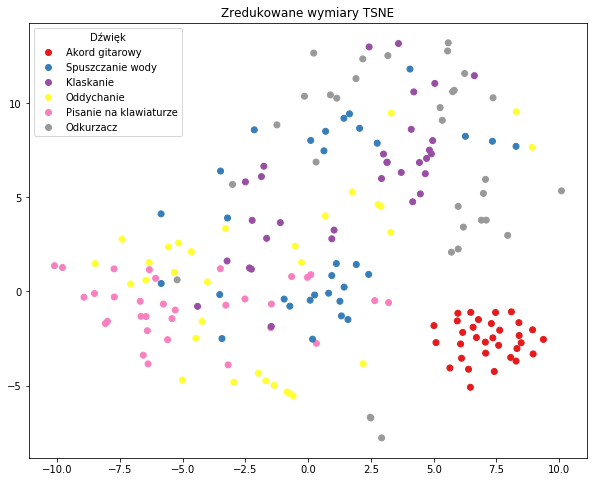

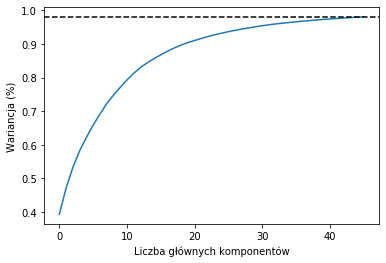

[PCA] Redukcja z 422 do 46 wymiarów
Próbek 240, atrybutów 422
Najlepsze parametry: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Dokładność: 0.85


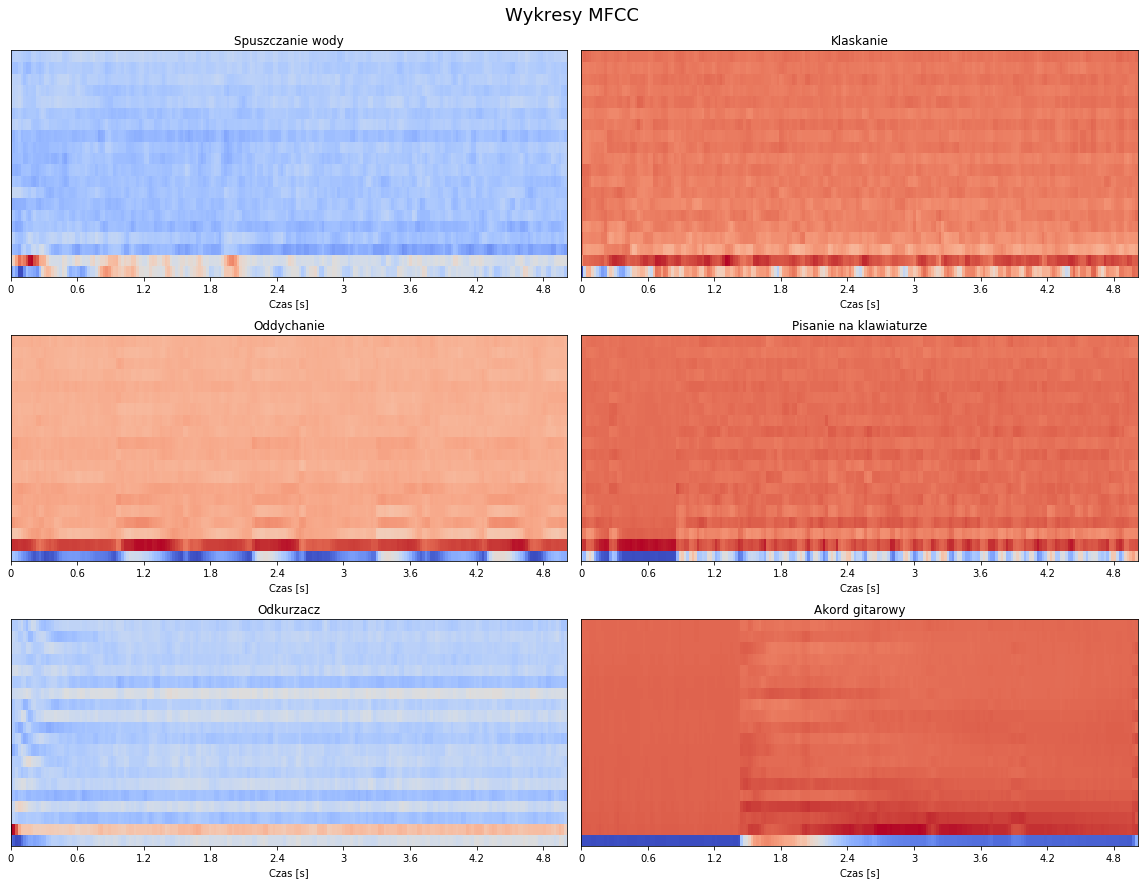

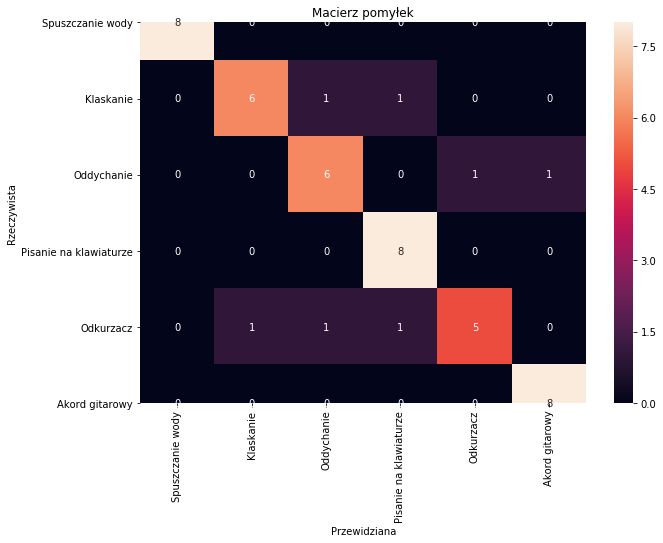

In [24]:
mfcc_result = testRepresentation(librosa.feature.mfcc, 'MFCC', n_mfcc=12)

**Obserwacje**

MFC jest reprezentacją krótkoterminowego widma mocy dźwięku, opartą na liniowej transformacji cosinusowej logarytmicznego spektrum mocy na nieliniowej skali częstotliwości.
 
MFCC to współczynniki, które wspólnie tworzą MFC. Pochodzą one z rodzaju cepstralnej reprezenacji klipu audio.
 
Różnica między cepstrum a cepstrum o częstotliwości mel (mel-frequecny cepstrum) polega na tym, że w MFC pasma częstotliwości są równomiernie rozmieszczone na skali mel, co przybliża reakcję ludzkiego układu słuchowego bliżej niż liniowo rozmieszczone pasma częstotliwości używane w normalnym cepstrum. To zniekształcenie częstotliwości może pozwolić na lepszą reprezentację dźwięku, na przykład podczas kompresji audio.
 
MFCC są często używane jako cechy w systemach rozpoznawania mowy. MFCC również coraz częściej wykorzystywane są do wyszukiwania informacji muzycznych, takich jak klasyfikacja gatunku muzycznego, pomiar podobieństwa audio itd.

Interpretacja otrzymanych wykresów jest nietrywiala i nieczęsto stosowana w literaturze.  
Źródło: What's the correct graphical interpretation of a series of MFCC vectors?  
https://dsp.stackexchange.com/questions/38830/whats-the-correct-graphical-interpretation-of-a-series-of-mfcc-vectors

Mel spectrogram

Mel spectrogram:


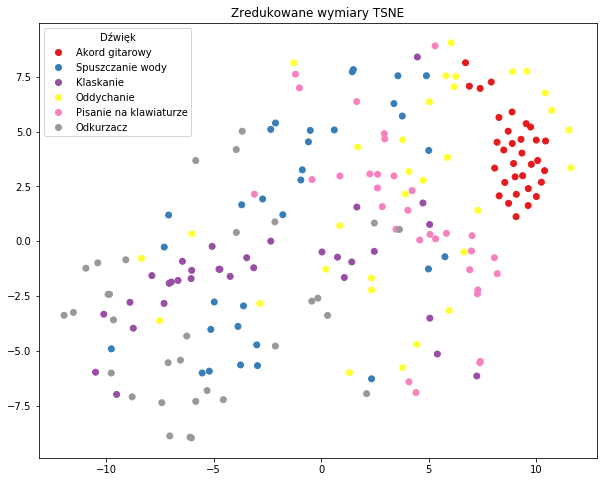

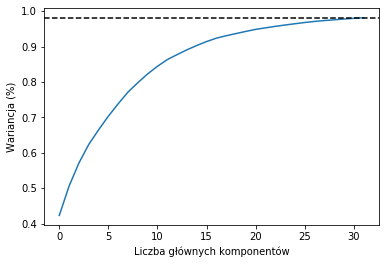

[PCA] Redukcja z 770 do 32 wymiarów
Próbek 240, atrybutów 770
Najlepsze parametry: {'C': 100, 'kernel': 'linear'}
Dokładność: 0.73


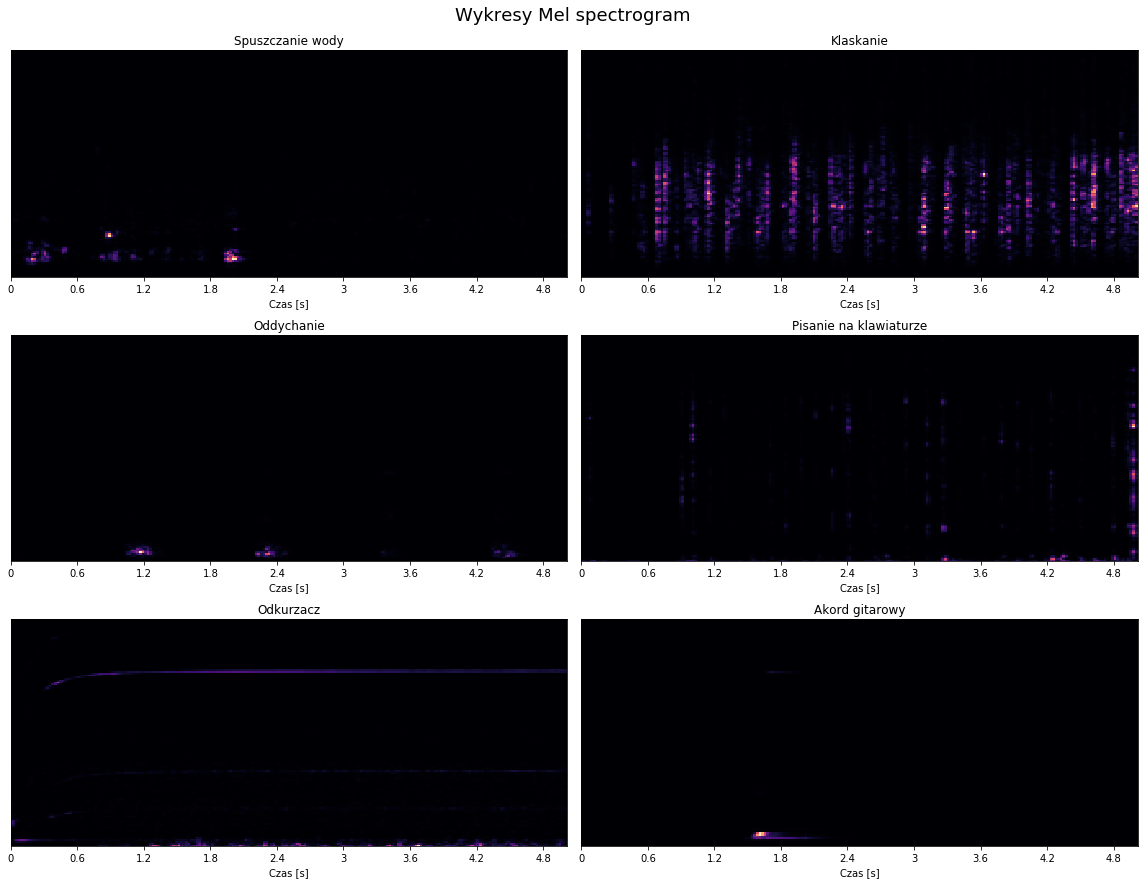

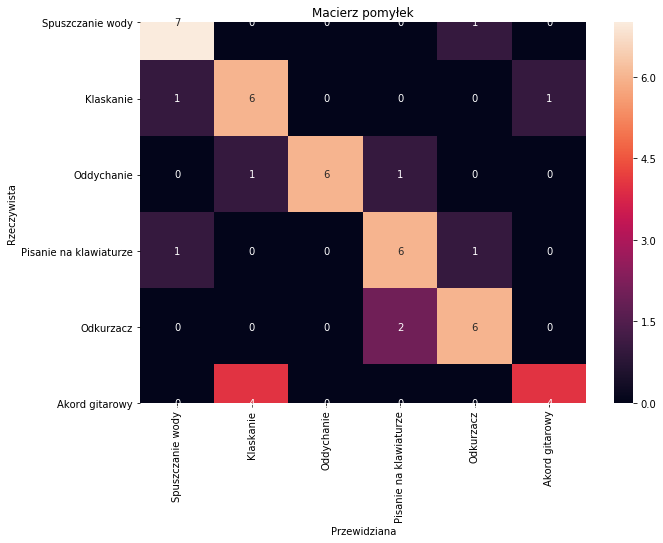

In [25]:
mel_result = testRepresentation(librosa.feature.melspectrogram, 'Mel spectrogram')

**Obserwacje** 

Mel spectrogram składa się z punktów o róznych kolorach. Kolor czarny oznacza moc -80 dB natomiast jasniejsze kolory oznaczają wyższą moc. 
 
Z powyższych wykresów Mel spectrogram-u można zauważyć różnice między sygnaturami dźwięku przedstawicieli różnych klas dźwięków. 
 
Spectrogram dla **klaskania** pokazuje duża intensywność powtarzającą się wielokrotnie w odstępach od siebie.
 
Spectrogram dla **odkurzacza** z kolei pokazuje nieco niższą moc, jednakże sygnał jest ciągły i występuje przez całe 5-sekundowe okno akwizycji.
 
**Pisanie na klawiaturze** ma spectrogram zbliżony do klaskania, jednakże w tym przypadku widać, że intensywność dzwięków jest znacznie mniejsza. 
 
Ze spectrogramu **akordu gitarowego** widzimy, że na nagraniu występuje cisza, aż do momentu w którym nagrany został akord. Wtedy to widoczny staje się skok intensywności, który stopniowo zmniejsza się co reprezentuje czestosliwości rezonansowe.
 
Przy **oddychaniu** widać skupiska mocniejszych dzięków, które odpowiadają wdychaniu i wydychaniu, które jest rejestrowane przez mikrofon.
 
**Spuszcanie wody** charakteryzuje sie intensywnym sygnałem, który szybko zanika. Spectrogram ten jest zbliżony do tego od akordu gitarowego, jednakże w tym przypadku widać, że dzwięk jest bardziej chaotyczny i nieregularny.

Constant-Q Transform chromagram

CQT:


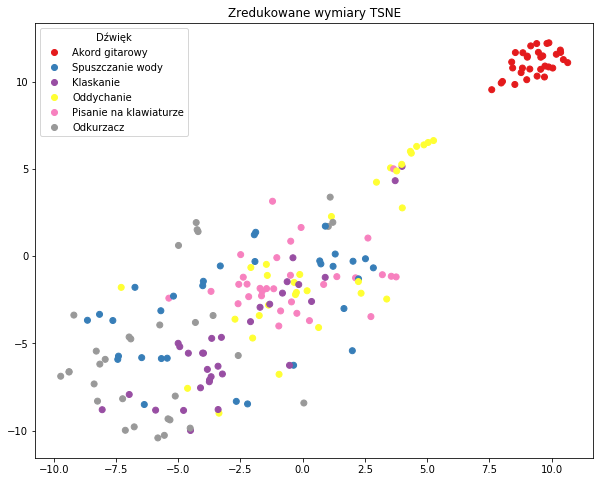

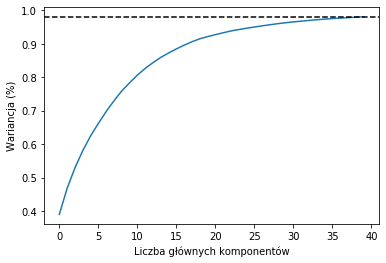

[PCA] Redukcja z 422 do 40 wymiarów
Próbek 240, atrybutów 422
Najlepsze parametry: {'C': 0.5, 'kernel': 'linear'}
Dokładność: 0.85


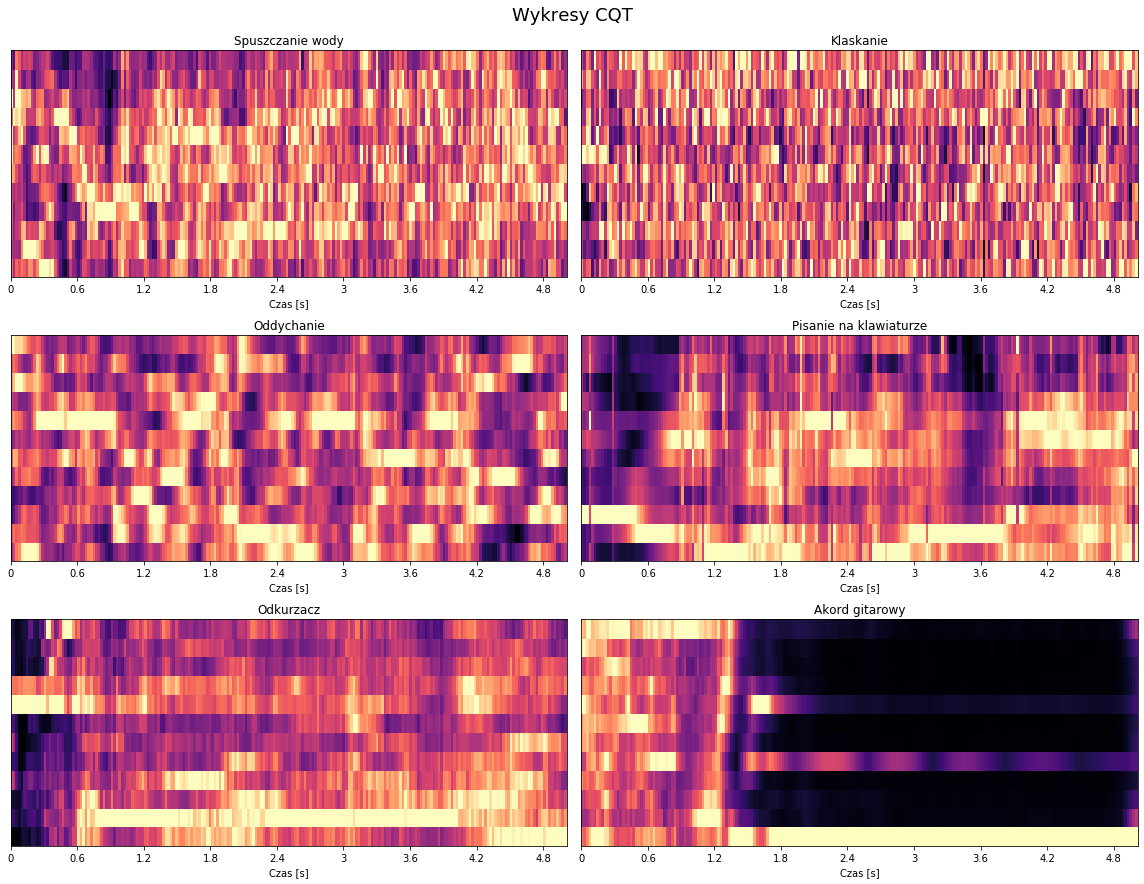

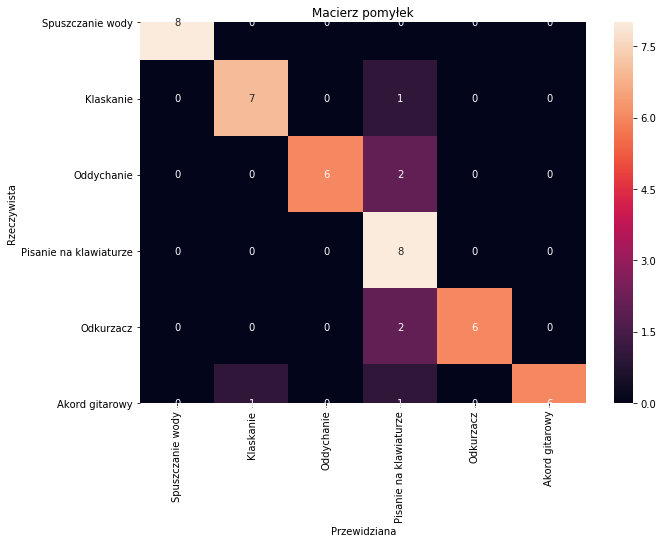

In [26]:
cqt_result = testRepresentation(librosa.feature.chroma_cqt, 'CQT')

**Obserwacje**

Spektrogram CQT (Constant Q Transform) jest przydatny do wykrywania i klasyfikowania muzyki ze względu na to, ęe jego cechą jest transformacja o stałym iloczynie częstotliwości do rozdzielczości. To pozwala łatwo wykrywać harmionię.

Na powyższych wykresach trudno odróżnić od siebie **spuszczanie wody** i **klasanie**. Obydwie te próbki cechują się dużą ilością chaosu i szumu. Mimo to **klaskanie** ma gwałtowniejszą i bardziej regularną strukturę jednak ta informacja zostaje zatracona na spektrogramie. 

Rzecz ma się podobnie w przypadku **oddychania** i **pisania na klawiaturze** choć tutaj na spektrogramie **pisania na klawiaturze** wyraźnie widać, że są miejsca w których wysokie dźwęki przeważają nad niskimi. Są to oczywiście chwile intensywnego **pisania na klawiaturze** o ostrym brzmieniu. W przypadku klawiatury laptopowej spektogram ten byłby bliższy spektogramowi **oddychania** ze względu na bardziej wygłuszone odgłosy klawiszy.

**Odkurzacz** można rozpoznać na spektrogramnie bez wnikliwej analizy. Motywem wiodącym jest wysoki dźwięk, a akompaniamentem ztłumiony bas.

CQT zgodnie z założeniem wybitnie dobrze radzi sobie z harmaoniami w związku z czym spektrogram **akordu C-dur** wyróżnia się spośród pozostałych dzięki odseparowanym częstotliwościom.

Short-Time Fourier Transform. Dodatkowo sprawdzamy też tę reprezentację, ponieważ również stosowana jest do klasyfikacji:  
[6] Comparison of Time-Frequency Representations for Environmental Sound Classification using Convolutional Neural Networks, Muhammad Huzaifah, 2017

STFT:


D:\Programmes\Anaconda3\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


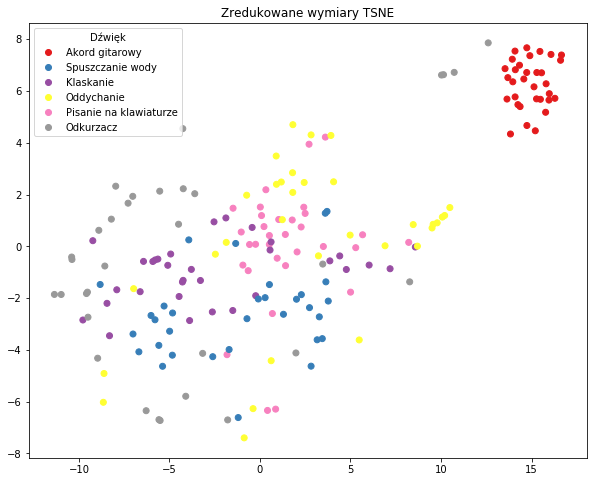

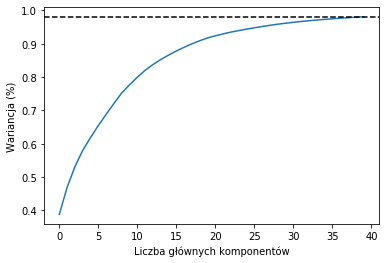

[PCA] Redukcja z 422 do 40 wymiarów
Próbek 240, atrybutów 422
Najlepsze parametry: {'C': 1, 'kernel': 'linear'}
Dokładność: 0.56


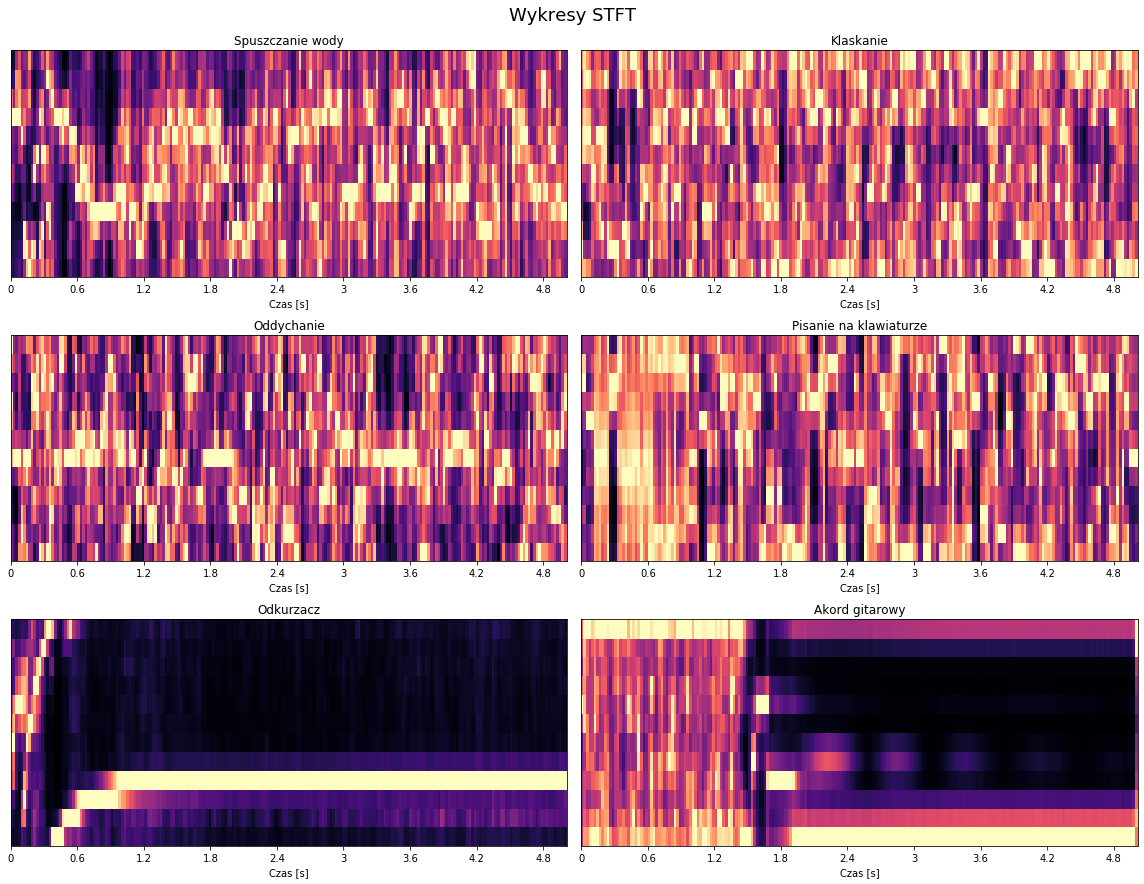

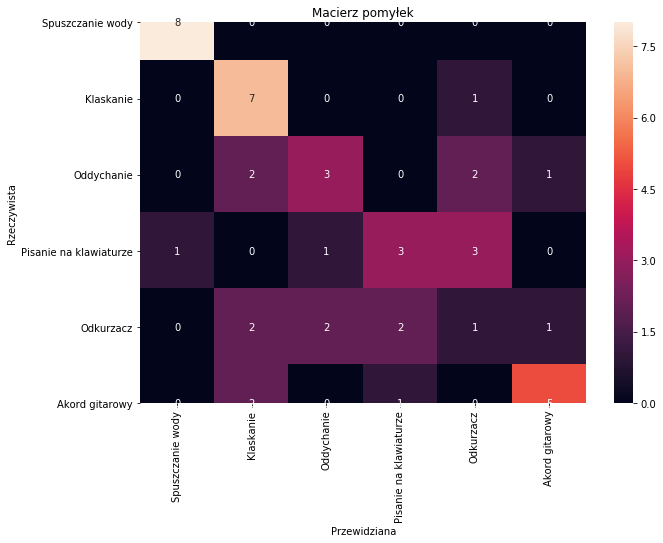

In [27]:
stft_result = testRepresentation(librosa.feature.chroma_stft, 'STFT')

**Obserwacje**

Spektrogramy po STFT przypominają z natury spektrogramy po CQT. Jest to szczególnie widoczne dla dźwięków z **odkurzacza** oraz **akordu gitarowego**. 

**Akord gitarowy** jest co prawda mniej wyraźny niż po CQT i widać duże zaburzenia szczególnie na początku pliku dzwiękowego niemniej jednak wciąż jest łatwo rozpoznawalny. 

**Odkurzacz** który po CQT można było rozpoznać dzięki odrobinie intuicji teraz również stał się wyraźnym, odrębnym spektrogramem na którym widać wyraźnie owy wspomniany wcześniej motyw przewodni będący wysokimi dźwiękami.

**Pisanie na klawiaturze** oraz **klaskanie** są od siebie niemal niczm nie różniącymi się spektrogramami. Niestety wskazanie konkretnych oznak uderzeń o dłonie czy też o klawisze jest trudne, ogranicza się do zauważenia rozbłysków na skrajnych pasmach spektrogramu.

Spektrogramy **spuszczania wody** i **oddychania** również są do siebie bardzo podobne, nie widać na nich gwałtowności a skrajne pasma są dość ciche.

**Wnioski:** Najwyższą dokładność osiągamy przy użyciu reprezentacji *MFCC*. Dokładność (Accuracy) jest tutaj surowym kryterium pozwalającym określić jakość wytrenowanego modelu, ponieważ klasy są zabalansowane, każda jest reprezentowana przez taką samą ilość próbek.

Reprezentacja danych dla finalnego modelu składa się z:
- MFCC (średnia, odchylenie standardowe, mediana)
- Mel spectogram (średnia, odchylenie standardowe, mediana)
- Zero-crossing rate (średnia, odchylenie standardowe)

Wybór poszczególnych reprezentacji opierał się na powyższych testach i metrykach. Ponadto dobór był w głównej mierze podyktowany prawidłową klasyfikacją dźwięków ze zbioru weryfikacyjnego, który składał się w całości przez nas nagranych dźwięków.

Utwórz reprezentacje klasyfikatora

In [28]:
model = commons.SoundRecognizer(*mfcc_result[:3], categories, librosa.feature.mfcc, n_mfcc=12)

Zapisz wytrenowany model, który może zostać wczytany w docelowej aplikacji

In [29]:
import joblib

model_name = 'model.joblib'
model_files = joblib.dump(model, model_name)
model = joblib.load(model_name) # In order to load the dumped model

Zweryfikuj działanie modelu na próbkach nagranych ręcznie

In [30]:
VERIFICATION_PATH = 'verification/'
verification = {
    'files': [VERIFICATION_PATH + 'Oddychanie.wav', VERIFICATION_PATH + 'Akord_gitarowy.wav', VERIFICATION_PATH + 'Klaskanie.wav', VERIFICATION_PATH + 'Pisanie_na_klawiaturze.wav', VERIFICATION_PATH + 'Spuszczanie_wody.wav', VERIFICATION_PATH + 'Odkurzacz.wav'],
    'expected': ['Oddychanie', 'Akord gitarowy', 'Klaskanie', 'Pisanie na klawiaturze', 'Spuszczanie wody', 'Odkurzacz']
}

print(f'Rezultat:\t{model.classifyFile(verification["files"])}')
print(f'Spodziewane:\t{verification["expected"]}')

Rezultat:	['Oddychanie', 'Akord gitarowy', 'Klaskanie', 'Pisanie na klawiaturze', 'Spuszczanie wody', 'Odkurzacz']
Spodziewane:	['Oddychanie', 'Akord gitarowy', 'Klaskanie', 'Pisanie na klawiaturze', 'Spuszczanie wody', 'Odkurzacz']
